In [75]:
# import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder



In [76]:

# Charger le fichier CSV depuis son emplacement local
file_path = r"C:\Users\nseke\Documents\GitHub\RUSH-4---Camp-market\Camp_Market_Cleaned_Income.csv"
df = pd.read_csv(file_path)

# Afficher les premières lignes
print(df.head())


     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  AcceptedCmp3  AcceptedCmp4  \
0      9/4/12       58       635  ...             0             0   
1      3/8/14       38        11  ...             0             0   
2     8/21/13       26       426  ...             0             0   
3     2/10/14       26        11  ...             0             0   
4     1/19/14       94       173  ...             0             0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  \
0             0             0             0 

Démarrage de l'entraînement des modèles...
Entraînement terminé avec succès.

             RÉSULTATS DU MODÈLE              
                        AUC  Precision  Recall
Logistic Regression  0.8574     0.4444  0.7473
Random Forest        0.8512     0.6667  0.0879
Gradient Boosting    0.8607     0.6905  0.3187

Matrice de confusion (exemple pour Gradient Boosting):
[[507  13]
 [ 62  29]]


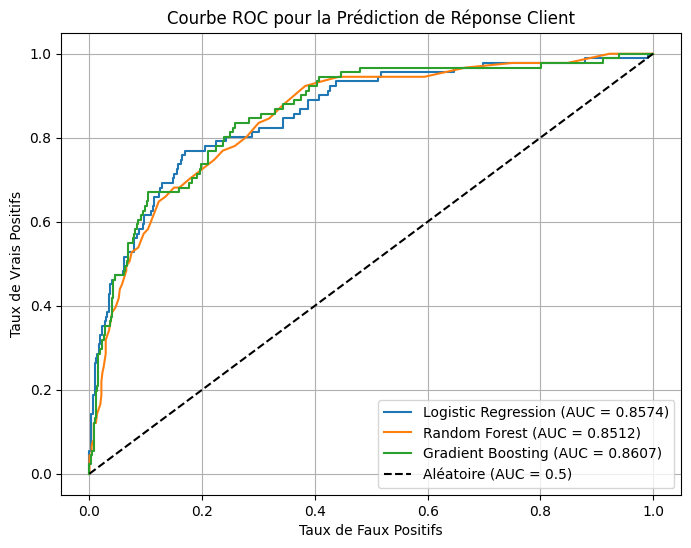


 Facteurs influençant la réponse client 

Top 10 des Features Influentes (Random Forest):
Recency             0.1437
MntMeatProducts     0.0936
Income              0.0930
MntGoldProds        0.0882
MntWines            0.0866
Age                 0.0588
MntSweetProducts    0.0586
MntFishProducts     0.0571
MntFruits           0.0567
AcceptedCmp3        0.0561
dtype: float64


C:\Users\nseke\AppData\Local\Temp\ipykernel_39176\1060238143.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_feature_importance.values, y=rf_feature_importance.index, palette="viridis")


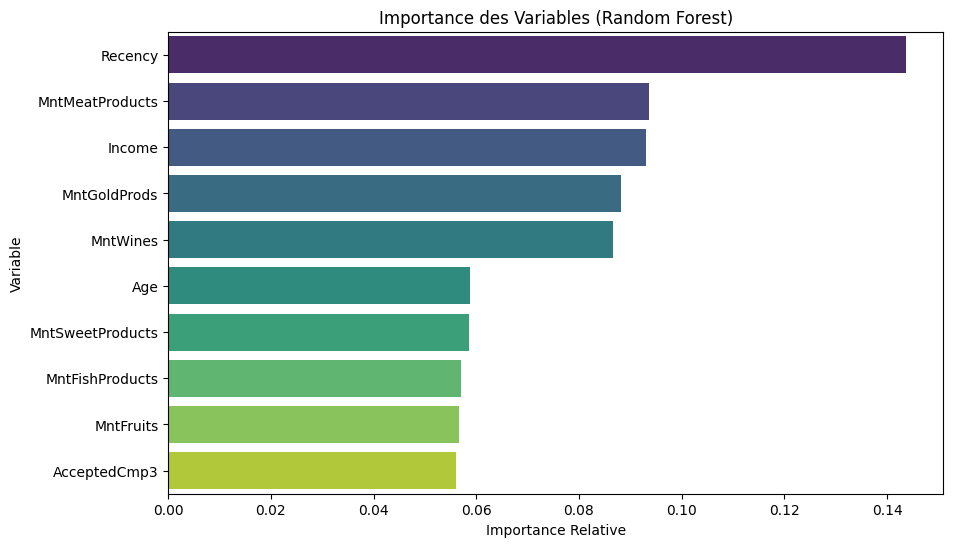


Top 10 des Features Influentes (Gradient Boosting):
Recency             0.1804
AcceptedCmp3        0.1198
MntMeatProducts     0.1121
AcceptedCmp5        0.0846
MntWines            0.0751
AcceptedCmp1        0.0676
Income              0.0656
MntGoldProds        0.0480
MntSweetProducts    0.0422
Age                 0.0327
dtype: float64


C:\Users\nseke\AppData\Local\Temp\ipykernel_39176\1060238143.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_feature_importance.values, y=gb_feature_importance.index, palette="plasma")


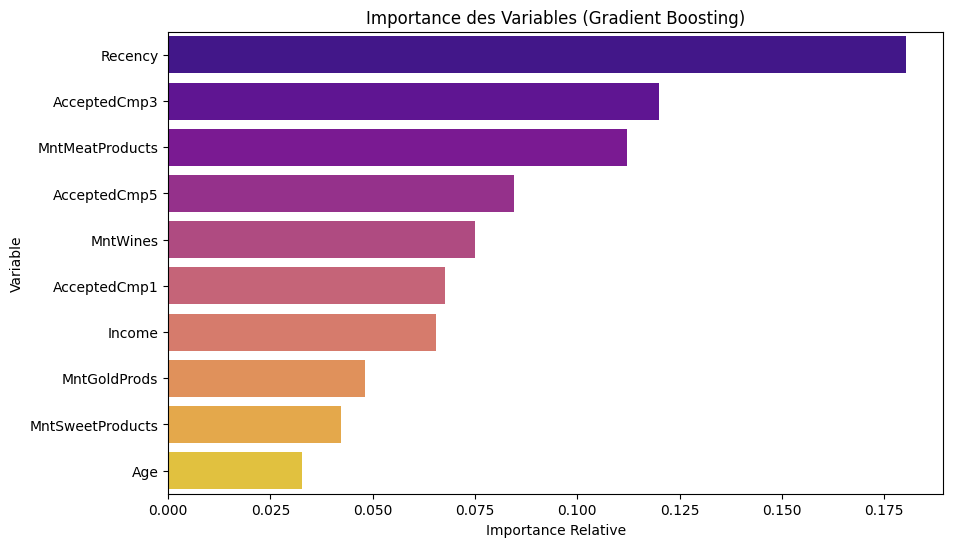

In [77]:
# Définition des features
rfm_features = [col for col in df.columns if col.startswith('Mnt')] + ['Recency']
demographic_features = ['Income', 'Year_Birth', 'Kidhome', 'Teenhome']
categorical_features = ['Education', 'Marital_Status']
campaign_history_features = [col for col in df.columns if col.startswith('AcceptedCmp')]
feature_cols = rfm_features + demographic_features + categorical_features + campaign_history_features

# Création du DataFrame de travail
data = df[feature_cols + ['Response']].copy()

# Traitement des valeurs manquantes (Suppression des lignes avec Income manquant)
data.dropna(subset=['Income'], inplace=True)

# Conversion de 'Year_Birth' en 'Age'
data['Age'] = 2025 - data['Year_Birth']
data.drop('Year_Birth', axis=1, inplace=True)

# ==============================================================================
# 2. Définition de la variable cible et des features
# ==============================================================================
X = data.drop('Response', axis=1)
y = data['Response']

# ==============================================================================
# 3. Division des données en Train/Test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# ==============================================================================
# 4. Préprocessing et Pipelines de Modélisation
# ==============================================================================

# Définition des colonnes numériques (toutes les autres après avoir exclu les catégories)
numeric_features = [col for col in X_train.columns if col not in categorical_features]

# Configuration du préprocesseur (StandardScaler pour le numérique, OneHotEncoder pour le catégoriel)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Pipelines pour les trois modèles
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000))])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))])

pipeline_gb = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=100))])

# Entraînement des modèles
print("Démarrage de l'entraînement des modèles...")
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)
pipeline_gb.fit(X_train, y_train)
print("Entraînement terminé avec succès.")


# ==============================================================================
# 5. Évaluation des Performances
# ==============================================================================

models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "Gradient Boosting": pipeline_gb
}

metrics_results = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)

    metrics_results[name] = {
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    # Affichage de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

# Affichage des métriques et courbes
print("\n==============================================")
print("             RÉSULTATS DU MODÈLE              ")
print("==============================================")
metrics_df = pd.DataFrame({
    'AUC': [res['AUC'] for res in metrics_results.values()],
    'Precision': [res['Precision'] for res in metrics_results.values()],
    'Recall': [res['Recall'] for res in metrics_results.values()]
}, index=metrics_results.keys())

print(metrics_df.round(4))
print("\nMatrice de confusion (exemple pour Gradient Boosting):")
print(metrics_results['Gradient Boosting']['Confusion Matrix'])

plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC pour la Prédiction de Réponse Client')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# ==============================================================================
# 6. Facteurs influençant la réponse client (Importance des Variables)
# ==============================================================================
print("\n==============================================")
print(" Facteurs influençant la réponse client ")
print("==============================================")

# Récupération des noms de features post-transformation
one_hot_encoder = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = list(one_hot_encoder.get_feature_names_out(categorical_features))
feature_names = numeric_features + encoded_feature_names


# Importance pour Random Forest
if 'Random Forest' in models:
    rf_importances = models['Random Forest'].named_steps['classifier'].feature_importances_
    rf_feature_importance = pd.Series(rf_importances, index=feature_names).sort_values(ascending=False).head(10)
    print("\nTop 10 des Features Influentes (Random Forest):")
    print(rf_feature_importance.round(4))

    # Graphique d'importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rf_feature_importance.values, y=rf_feature_importance.index, palette="viridis")
    plt.title('Importance des Variables (Random Forest)')
    plt.xlabel('Importance Relative')
    plt.ylabel('Variable')
    plt.show()


# Importance pour Gradient Boosting
if 'Gradient Boosting' in models:
    gb_importances = models['Gradient Boosting'].named_steps['classifier'].feature_importances_
    gb_feature_importance = pd.Series(gb_importances, index=feature_names).sort_values(ascending=False).head(10)
    print("\nTop 10 des Features Influentes (Gradient Boosting):")
    print(gb_feature_importance.round(4))
    
    # Graphique d'importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=gb_feature_importance.values, y=gb_feature_importance.index, palette="plasma")
    plt.title('Importance des Variables (Gradient Boosting)')
    plt.xlabel('Importance Relative')
    plt.ylabel('Variable')
    plt.show()